In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())


2.3.0+cu121
True


In [2]:
text ='Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text. At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model. One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in "memory" about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks. Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each characters appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time. Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants. In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology.'

cuda
Training with sequence length: 10


C:\Users\SirM\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\SirM\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch: 1, Train Loss: 2.9927, Train Accuracy: 0.1855, Val Loss: 2.6401, Val Accuracy: 0.2579, Duration: 1.03s
Epoch: 2, Train Loss: 2.5936, Train Accuracy: 0.2353, Val Loss: 2.4874, Val Accuracy: 0.2336, Duration: 0.78s
Epoch: 3, Train Loss: 2.5361, Train Accuracy: 0.2505, Val Loss: 2.4573, Val Accuracy: 0.2682, Duration: 0.85s
Epoch: 4, Train Loss: 2.4768, Train Accuracy: 0.2353, Val Loss: 2.4335, Val Accuracy: 0.2468, Duration: 0.91s
Epoch: 5, Train Loss: 2.4457, Train Accuracy: 0.2533, Val Loss: 2.3362, Val Accuracy: 0.2550, Duration: 0.85s
Epoch: 6, Train Loss: 2.3995, Train Accuracy: 0.2500, Val Loss: 2.3180, Val Accuracy: 0.2756, Duration: 0.85s
Epoch: 7, Train Loss: 2.3729, Train Accuracy: 0.2596, Val Loss: 2.2932, Val Accuracy: 0.2764, Duration: 0.84s
Epoch: 8, Train Loss: 2.3339, Train Accuracy: 0.2724, Val Loss: 2.2961, Val Accuracy: 0.2637, Duration: 0.86s
Epoch: 9, Train Loss: 2.3355, Train Accuracy: 0.2550, Val Loss: 2.3057, Val Accuracy: 0.2756, Duration: 0.84s
Epoch: 10,

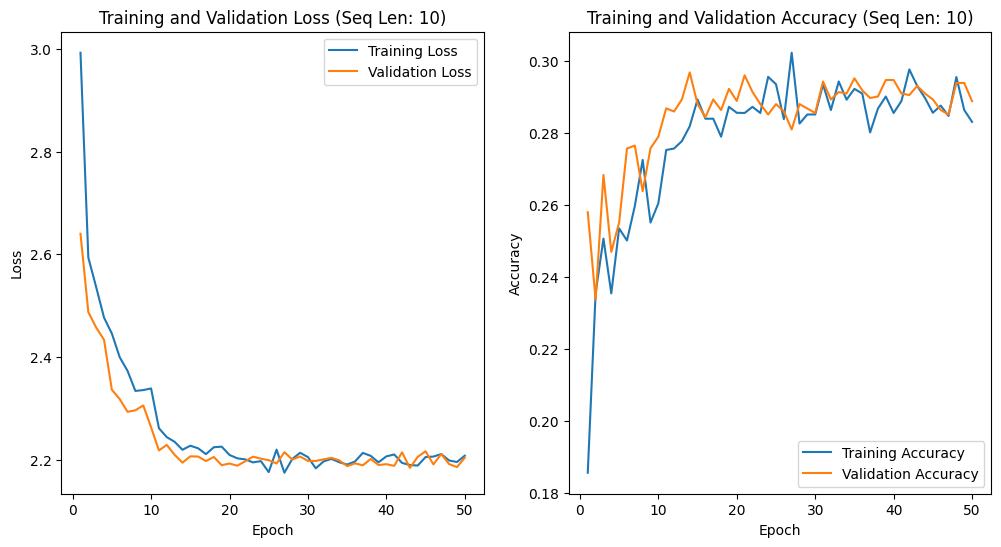

Training with sequence length: 20


C:\Users\SirM\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch: 1, Train Loss: 3.1577, Train Accuracy: 0.1231, Val Loss: 3.0593, Val Accuracy: 0.1475, Duration: 0.93s
Epoch: 2, Train Loss: 2.9425, Train Accuracy: 0.1696, Val Loss: 2.6830, Val Accuracy: 0.2213, Duration: 0.89s
Epoch: 3, Train Loss: 2.6586, Train Accuracy: 0.2279, Val Loss: 2.6814, Val Accuracy: 0.2136, Duration: 0.89s
Epoch: 4, Train Loss: 2.5958, Train Accuracy: 0.2367, Val Loss: 2.4886, Val Accuracy: 0.2740, Duration: 0.89s
Epoch: 5, Train Loss: 2.5192, Train Accuracy: 0.2436, Val Loss: 2.4619, Val Accuracy: 0.2604, Duration: 0.88s
Epoch: 6, Train Loss: 2.4805, Train Accuracy: 0.2528, Val Loss: 2.4001, Val Accuracy: 0.2664, Duration: 0.89s
Epoch: 7, Train Loss: 2.4447, Train Accuracy: 0.2490, Val Loss: 2.3802, Val Accuracy: 0.2705, Duration: 0.89s
Epoch: 8, Train Loss: 2.4116, Train Accuracy: 0.2642, Val Loss: 2.3598, Val Accuracy: 0.2469, Duration: 0.89s
Epoch: 9, Train Loss: 2.4134, Train Accuracy: 0.2597, Val Loss: 2.3565, Val Accuracy: 0.2719, Duration: 0.93s
Epoch: 10,

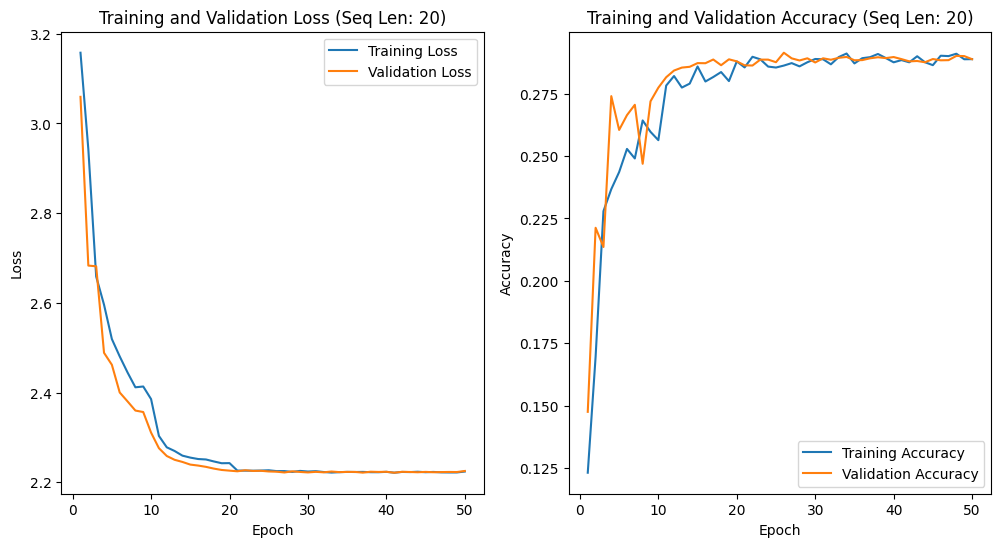

Training with sequence length: 30
Epoch: 1, Train Loss: 3.1576, Train Accuracy: 0.1296, Val Loss: 3.0060, Val Accuracy: 0.1071, Duration: 1.20s
Epoch: 2, Train Loss: 2.8050, Train Accuracy: 0.2031, Val Loss: 2.6469, Val Accuracy: 0.2351, Duration: 1.18s
Epoch: 3, Train Loss: 2.6307, Train Accuracy: 0.2437, Val Loss: 2.5526, Val Accuracy: 0.2492, Duration: 1.19s
Epoch: 4, Train Loss: 2.5464, Train Accuracy: 0.2470, Val Loss: 2.4478, Val Accuracy: 0.2678, Duration: 1.18s
Epoch: 5, Train Loss: 2.4912, Train Accuracy: 0.2441, Val Loss: 2.3999, Val Accuracy: 0.2692, Duration: 1.18s
Epoch: 6, Train Loss: 2.4586, Train Accuracy: 0.2466, Val Loss: 2.3775, Val Accuracy: 0.2662, Duration: 1.19s
Epoch: 7, Train Loss: 2.4230, Train Accuracy: 0.2595, Val Loss: 2.3432, Val Accuracy: 0.2740, Duration: 1.18s
Epoch: 8, Train Loss: 2.3893, Train Accuracy: 0.2538, Val Loss: 2.3227, Val Accuracy: 0.2776, Duration: 1.18s
Epoch: 9, Train Loss: 2.3837, Train Accuracy: 0.2536, Val Loss: 2.3068, Val Accuracy: 

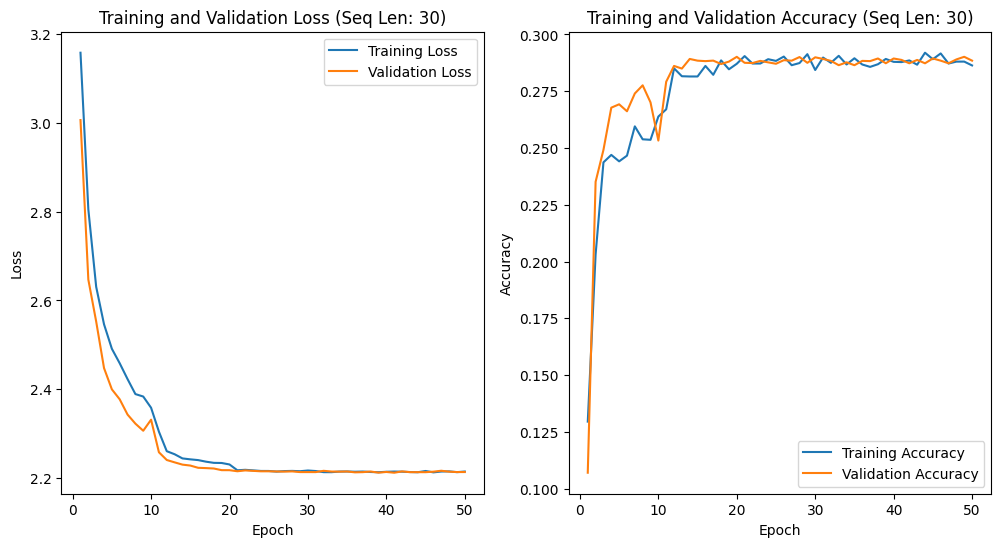

Overall accuracy for sequence length 10: 0.2887
Overall accuracy for sequence length 20: 0.2888
Overall accuracy for sequence length 30: 0.2885
Predicted next character for input of length 10: 'n'
Predicted next character for input of length 20: 'n'
Predicted next character for input of length 30: 'n'


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import time
import matplotlib.pyplot as plt

# Create character mapping
chars = sorted(set(text))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

# Helper function to create input and target sequences
def create_sequences(text, seq_length):
    inputs = []
    targets = []
    for i in range(len(text) - seq_length):
        input_seq = text[i:i + seq_length]
        target_char = text[i + seq_length]
        inputs.append([char_to_ix[ch] for ch in input_seq])
        targets.append(char_to_ix[target_char])
    return torch.tensor(inputs, dtype=torch.long), torch.tensor(targets, dtype=torch.long)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

# Incorporate Positional Encoding in CharTransformer
class CharTransformer(nn.Module):
    def __init__(self, vocab_size, hidden_size, nhead, num_layers, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size  # Store hidden_size as an instance variable
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_encoder = PositionalEncoding(hidden_size)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=nhead, dropout=dropout),
            num_layers)
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, src):
        embedded = self.embedding(src) * np.sqrt(self.hidden_size)  # Use self.hidden_size here
        embedded = self.pos_encoder(embedded)
        transformer_output = self.transformer_encoder(embedded)
        return self.fc_out(transformer_output[:, -1])

# Training and evaluation function
def train_and_evaluate(model, data_loader, criterion, optimizer, scheduler, device, clip):
    model.to(device)
    model.train()
    total_loss = 0
    total_accuracy = 0  # Track total accuracy
    start_time = time.time()

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        optimizer.step()
        total_loss += loss.item()
        total_accuracy += (output.argmax(1) == targets).float().mean().item()

    # Adjust the learning rate
    scheduler.step()
    duration = time.time() - start_time
    total_accuracy /= len(data_loader)  # Calculate mean accuracy over all batches

    # Validation
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            val_loss += criterion(output, targets).item()
            val_accuracy += (output.argmax(1) == targets).float().mean().item()

    val_loss /= len(data_loader)
    val_accuracy /= len(data_loader)
    return total_loss / len(data_loader), total_accuracy, val_loss, val_accuracy, duration

def predict_next_char(model, initial_str, seq_length, char_to_ix, ix_to_char):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Adjust the input string to the expected sequence length
        initial_str = initial_str[-seq_length:]  # Keep only the last `seq_length` characters
        if len(initial_str) < seq_length:
            initial_str = (' ' * (seq_length - len(initial_str))) + initial_str  # Pad with spaces if too short
        # Convert string to a tensor
        input_tensor = torch.tensor([char_to_ix[c] for c in initial_str], dtype=torch.long).unsqueeze(0).to(device)
        # Get output from model
        output = model(input_tensor)
        # Convert output probabilities to predicted character index
        predicted_index = output.argmax(1).item()
        # Convert index to character
        predicted_char = ix_to_char[predicted_index]
        return predicted_char

# Prepare data for different sequence lengths
sequence_lengths = [10, 20, 30]
results = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
models = {}  # Dictionary to store models

# Train and save models
for seq_length in sequence_lengths:
    print(f"Training with sequence length: {seq_length}")
    inputs, targets = create_sequences(text, seq_length)
    dataset = TensorDataset(inputs, targets)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    model = CharTransformer(len(chars), 256, 8, 6, dropout=0.001).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    clip = 1.0

    epochs = 50  # Assuming a specific number of epochs
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(epochs):
        train_loss, train_accuracy, val_loss, val_accuracy, duration = train_and_evaluate(
            model, data_loader, criterion, optimizer, scheduler, device, clip)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Duration: {duration:.2f}s")

    # Save model
    torch.save(model.state_dict(), f'model_{seq_length}.pth')
    print(f"Model for sequence length {seq_length} saved to disk.")
    models[seq_length] = model  # Store the model in the dictionary after training

    results[seq_length] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

    # Plotting training and validation metrics
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Loss (Seq Len: {seq_length})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy (Seq Len: {seq_length})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
# Print overall accuracy for each sequence length
for seq_length in sequence_lengths:
    print(f"Overall accuracy for sequence length {seq_length}: "
          f"{results[seq_length]['val_accuracies'][-1]:.4f}")
    

# Prediction after loading models
test_input = "Next character predictio"

for seq_length in sequence_lengths:
    model = CharTransformer(len(chars), 256, 8, 6, dropout=0.001).to(device)
    model.load_state_dict(torch.load(f'model_{seq_length}.pth'))
    model.eval()

    predicted_character = predict_next_char(model, test_input, seq_length, char_to_ix, ix_to_char)
    print(f"Predicted next character for input of length {seq_length}: '{predicted_character}'")

cuda
Seq Length: 20, Epoch:  1, Train Loss: 0.1728, Train Accuracy: 0.1369, Val Loss: 0.0321, Val Accuracy: 0.1621
Seq Length: 20, Epoch:  2, Train Loss: 0.1596, Train Accuracy: 0.1712, Val Loss: 0.0294, Val Accuracy: 0.2172
Seq Length: 20, Epoch:  3, Train Loss: 0.1503, Train Accuracy: 0.2097, Val Loss: 0.0274, Val Accuracy: 0.2582
Seq Length: 20, Epoch:  4, Train Loss: 0.1431, Train Accuracy: 0.2363, Val Loss: 0.0262, Val Accuracy: 0.2779
Seq Length: 20, Epoch:  5, Train Loss: 0.1378, Train Accuracy: 0.2527, Val Loss: 0.0252, Val Accuracy: 0.2935
Seq Length: 20, Epoch:  6, Train Loss: 0.1339, Train Accuracy: 0.2645, Val Loss: 0.0246, Val Accuracy: 0.3058
Seq Length: 20, Epoch:  7, Train Loss: 0.1309, Train Accuracy: 0.2745, Val Loss: 0.0241, Val Accuracy: 0.3153
Seq Length: 20, Epoch:  8, Train Loss: 0.1286, Train Accuracy: 0.2811, Val Loss: 0.0237, Val Accuracy: 0.3222
Seq Length: 20, Epoch:  9, Train Loss: 0.1268, Train Accuracy: 0.2866, Val Loss: 0.0234, Val Accuracy: 0.3276
Seq L

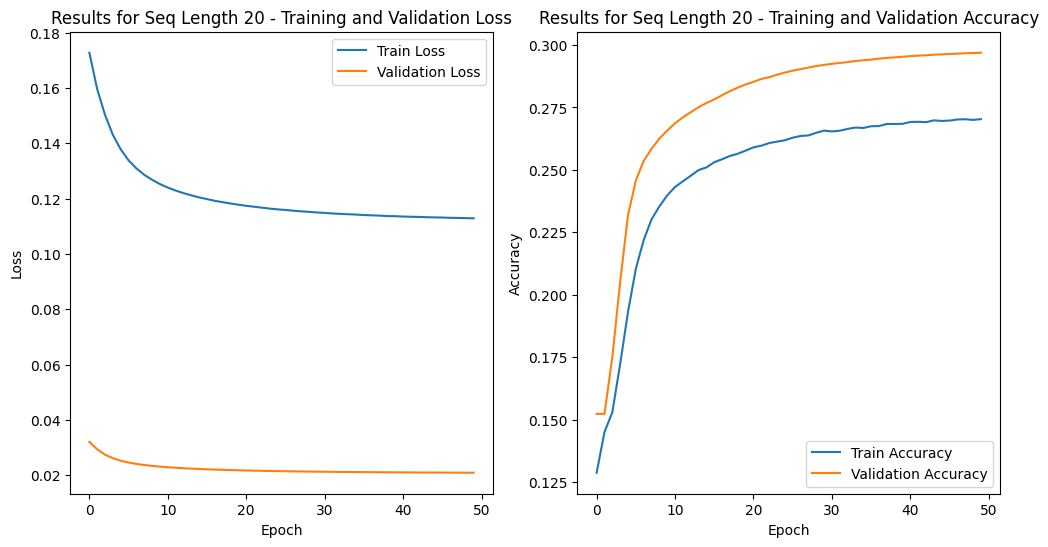

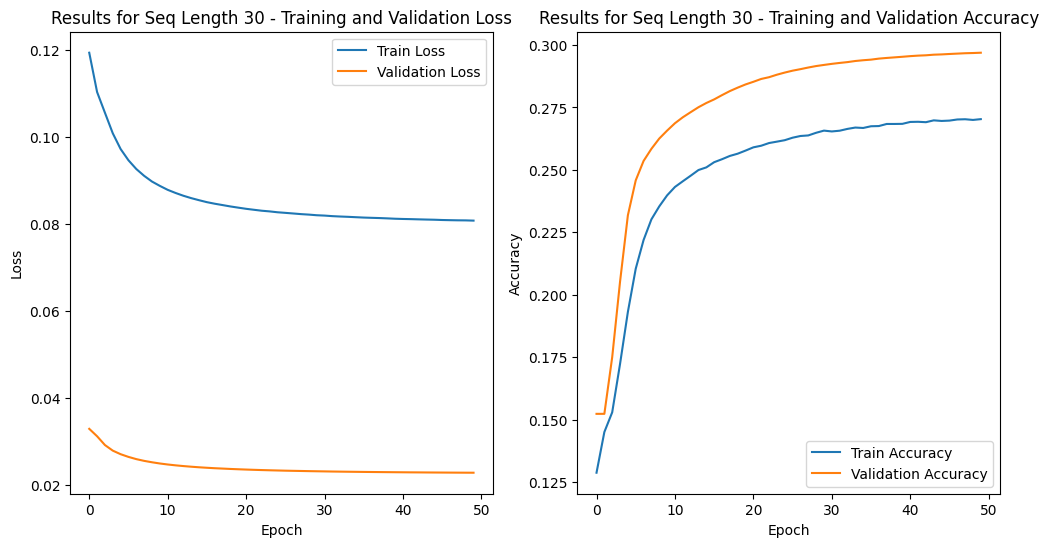

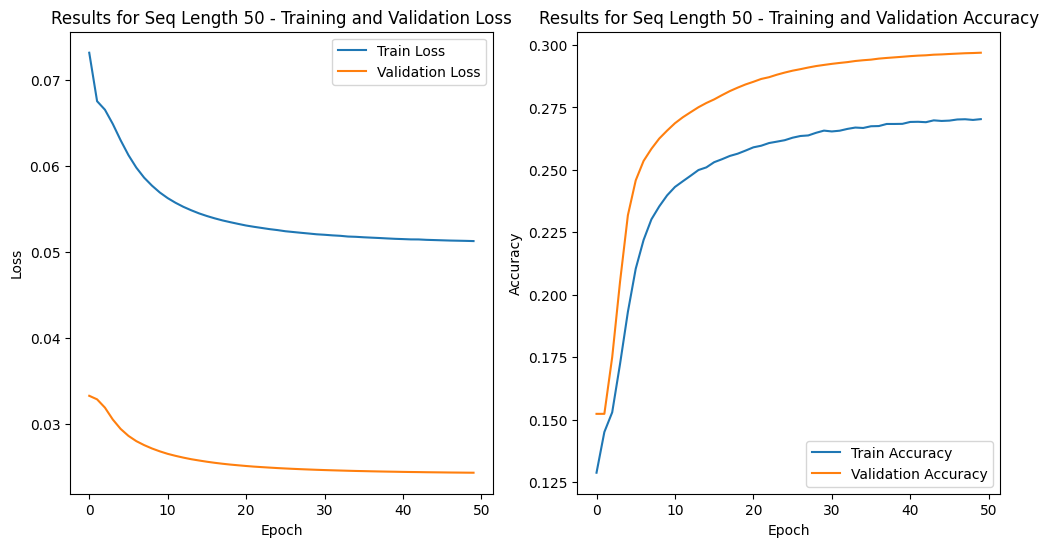

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import requests
import math
import time
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# Download and prepare the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text

# Character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}
vocab_size = len(chars)

# Data Preparation
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = char_to_int[string[c]]
    return tensor

def batchify(data, batch_size, seq_length):
    # Calculate the number of batches that fit completely in the dataset
    nbatch = data.size(0) // (batch_size * seq_length)
    # Trim data to make it fit perfectly
    data = data.narrow(0, 0, nbatch * batch_size * seq_length)
    # Reshape data to batch_size batches
    data = data.view(batch_size, -1).t().contiguous()
    return data.to(device)

# Prepare the initial tensor from the text
data = char_tensor(text).to(device)
BATCH_SIZE = 100
SEQ_LENGTHS = [20, 30, 50]

# Define the model
class TransformerModel(nn.Module):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.transformer = nn.Transformer(ninp, nhead, nlayers, dropout=dropout)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer(src, src, src_mask)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Training and Evaluation Functions
ntokens = vocab_size  # Correct use of vocabulary size
emsize = 200  # Embedding dimension
nhid = 200    # Dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2   # Number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2     # Number of heads in the multiheadattention models
dropout = 0.2  # Dropout value

model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def get_batch(source, i, seq_len):
    seq_len = min(seq_len, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

def accuracy(output, targets):
    preds = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct = preds.eq(targets.view_as(preds)).sum().item()
    return correct / len(targets)

def train(model, train_data, criterion, optimizer, scheduler, ntokens, device, seq_len):
    model.train()
    total_loss = 0.
    total_correct = 0
    total_elements = 0
    start_time = time.time()

    for i in range(0, train_data.size(0) - seq_len, seq_len):
        data, targets = get_batch(train_data, i, seq_len)
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        output = model(data, model._generate_square_subsequent_mask(data.size(0)).to(device))
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        total_correct += accuracy(output.view(-1, ntokens), targets) * len(targets)
        total_elements += len(targets)

    return total_loss / (i + 1), total_correct / total_elements

def evaluate(eval_model, data_source, criterion, ntokens, device, seq_len):
    eval_model.eval()
    total_loss = 0.
    total_correct = 0
    total_elements = 0

    with torch.no_grad():
        for i in range(0, data_source.size(0) - seq_len, seq_len):
            data, targets = get_batch(data_source, i, seq_len)
            data = data.to(device)
            targets = targets.to(device)

            output = eval_model(data, eval_model._generate_square_subsequent_mask(data.size(0)).to(device))
            loss = criterion(output.view(-1, ntokens), targets)
            total_loss += len(data) * loss.item()
            total_correct += accuracy(output.view(-1, ntokens), targets) * len(targets)
            total_elements += len(targets)

    return total_loss / total_elements, total_correct / total_elements

# Prepare the data for each sequence length and train separately
SEQ_LENGTHS = [20, 30, 50]
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

# Training loop for each sequence length
for SEQ_LENGTH in SEQ_LENGTHS:
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Prepare the data specific to this sequence length
    train_data = batchify(data, BATCH_SIZE, SEQ_LENGTH)

    # Reinitialize the model and optimizer for each sequence length
    model = TransformerModel(vocab_size, 200, 2, 200, 2, 0.2).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=5e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    # Train for a predetermined number of epochs
    epochs = 50
    for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train(model, train_data, criterion, optimizer, scheduler, vocab_size, device, SEQ_LENGTH)
        val_loss, val_accuracy = evaluate(model, train_data, criterion, vocab_size, device, SEQ_LENGTH)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Seq Length: {SEQ_LENGTH}, Epoch: {epoch:2d}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        scheduler.step()

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

def plot_results(train_loss, val_loss, train_accuracy, val_accuracy, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Training and Validation Accuracy')
    plt.legend()

    plt.show()
    
for i, seq_len in enumerate(SEQ_LENGTHS):
    plot_results(all_train_losses[i], all_val_losses[i], all_train_accuracies[i], all_val_accuracies[i], f"Results for Seq Length {seq_len}")


# Prediction for "We are accounted poor citi"
test_input = "We are accounted poor citi"

for seq_length in sequence_lengths:
    model = CharTransformer(len(chars), 256, 8, 6, dropout=0.001).to(device)
    model.load_state_dict(torch.load(f'model_{seq_length}.pth'))
    model.eval()

    predicted_character = predict_next_char(model, test_input, seq_length, char_to_ix, ix_to_char)
    print(f"Predicted next character for '{test_input}' with input of length {seq_length}: '{predicted_character}'")

In [11]:
    english_to_french = [

    ("I am cold", "J'ai froid"),

    ("You are tired", "Tu es fatigué"),

    ("He is hungry", "Il a faim"),

    ("She is happy", "Elle est heureuse"),

    ("We are friends", "Nous sommes amis"),

    ("They are students", "Ils sont étudiants"),

    ("The cat is sleeping", "Le chat dort"),

    ("The sun is shining", "Le soleil brille"),

    ("We love music", "Nous aimons la musique"),

    ("She speaks French fluently", "Elle parle français couramment"),

    ("He enjoys reading books", "Il aime lire des livres"),

    ("They play soccer every weekend", "Ils jouent au football chaque week-end"),

    ("The movie starts at 7 PM", "Le film commence à 19 heures"),

    ("She wears a red dress", "Elle porte une robe rouge"),

    ("We cook dinner together", "Nous cuisinons le dîner ensemble"),

    ("He drives a blue car", "Il conduit une voiture bleue"),

    ("They visit museums often", "Ils visitent souvent des musées"),

    ("The restaurant serves delicious food", "Le restaurant sert une délicieuse cuisine"),

    ("She studies mathematics at university", "Elle étudie les mathématiques à l'université"),

    ("We watch movies on Fridays", "Nous regardons des films le vendredi"),

    ("He listens to music while jogging", "Il écoute de la musique en faisant du jogging"),

    ("They travel around the world", "Ils voyagent autour du monde"),

    ("The book is on the table", "Le livre est sur la table"),

    ("She dances gracefully", "Elle danse avec grâce"),

    ("We celebrate birthdays with cake", "Nous célébrons les anniversaires avec un gâteau"),

    ("He works hard every day", "Il travaille dur tous les jours"),

    ("They speak different languages", "Ils parlent différentes langues"),

    ("The flowers bloom in spring", "Les fleurs fleurissent au printemps"),

    ("She writes poetry in her free time", "Elle écrit de la poésie pendant son temps libre"),

    ("We learn something new every day", "Nous apprenons quelque chose de nouveau chaque jour"),

    ("The dog barks loudly", "Le chien aboie bruyamment"),

    ("He sings beautifully", "Il chante magnifiquement"),

    ("They swim in the pool", "Ils nagent dans la piscine"),

    ("The birds chirp in the morning", "Les oiseaux gazouillent le matin"),

    ("She teaches English at school", "Elle enseigne l'anglais à l'école"),

    ("We eat breakfast together", "Nous prenons le petit déjeuner ensemble"),

    ("He paints landscapes", "Il peint des paysages"),

    ("They laugh at the joke", "Ils rient de la blague"),

    ("The clock ticks loudly", "L'horloge tic-tac bruyamment"),

    ("She runs in the park", "Elle court dans le parc"),

    ("We travel by train", "Nous voyageons en train"),

    ("He writes a letter", "Il écrit une lettre"),

    ("They read books at the library", "Ils lisent des livres à la bibliothèque"),

    ("The baby cries", "Le bébé pleure"),

    ("She studies hard for exams", "Elle étudie dur pour les examens"),

    ("We plant flowers in the garden", "Nous plantons des fleurs dans le jardin"),

    ("He fixes the car", "Il répare la voiture"),

    ("They drink coffee in the morning", "Ils boivent du café le matin"),

    ("The sun sets in the evening", "Le soleil se couche le soir"),

    ("She dances at the party", "Elle danse à la fête"),

    ("We play music at the concert", "Nous jouons de la musique au concert"),

    ("He cooks dinner for his family", "Il cuisine le dîner pour sa famille"),

    ("They study French grammar", "Ils étudient la grammaire française"),

    ("The rain falls gently", "La pluie tombe doucement"),

    ("She sings a song", "Elle chante une chanson"),

    ("We watch a movie together", "Nous regardons un film ensemble"),

    ("He sleeps deeply", "Il dort profondément"),

    ("They travel to Paris", "Ils voyagent à Paris"),

    ("The children play in the park", "Les enfants jouent dans le parc"),

    ("She walks along the beach", "Elle se promène le long de la plage"),

    ("We talk on the phone", "Nous parlons au téléphone"),

    ("He waits for the bus", "Il attend le bus"),

    ("They visit the Eiffel Tower", "Ils visitent la tour Eiffel"),

    ("The stars twinkle at night", "Les étoiles scintillent la nuit"),

    ("She dreams of flying", "Elle rêve de voler"),

    ("We work in the office", "Nous travaillons au bureau"),

    ("He studies history", "Il étudie l'histoire"),

    ("They listen to the radio", "Ils écoutent la radio"),

    ("The wind blows gently", "Le vent souffle doucement"),

    ("She swims in the ocean", "Elle nage dans l'océan"),

    ("We dance at the wedding", "Nous dansons au mariage"),

    ("He climbs the mountain", "Il gravit la montagne"),

    ("They hike in the forest", "Ils font de la randonnée dans la forêt"),

    ("The cat meows loudly", "Le chat miaule bruyamment"),

    ("She paints a picture", "Elle peint un tableau"),

    ("We build a sandcastle", "Nous construisons un château de sable"),

    ("He sings in the choir", "Il chante dans le chœur")

]

Epoch 1, Train Loss: 4.7806, Train Accuracy: 0.1479, Val Loss: 4.3616, Val Accuracy: 0.1571
Epoch 2, Train Loss: 4.3494, Train Accuracy: 0.1779, Val Loss: 3.8553, Val Accuracy: 0.2306
Epoch 3, Train Loss: 3.8221, Train Accuracy: 0.2297, Val Loss: 3.2662, Val Accuracy: 0.2918
Epoch 4, Train Loss: 3.3273, Train Accuracy: 0.3068, Val Loss: 2.5834, Val Accuracy: 0.3633
Epoch 5, Train Loss: 2.8317, Train Accuracy: 0.3655, Val Loss: 2.0667, Val Accuracy: 0.5082
Epoch 6, Train Loss: 2.2734, Train Accuracy: 0.4333, Val Loss: 1.3613, Val Accuracy: 0.6531
Epoch 7, Train Loss: 1.6977, Train Accuracy: 0.5864, Val Loss: 0.9739, Val Accuracy: 0.7939
Epoch 8, Train Loss: 1.2848, Train Accuracy: 0.7038, Val Loss: 0.6550, Val Accuracy: 0.8857
Epoch 9, Train Loss: 1.0477, Train Accuracy: 0.7466, Val Loss: 0.5109, Val Accuracy: 0.9082
Epoch 10, Train Loss: 0.8510, Train Accuracy: 0.8039, Val Loss: 0.3608, Val Accuracy: 0.9143
Epoch 11, Train Loss: 0.6331, Train Accuracy: 0.8196, Val Loss: 0.2372, Val Acc

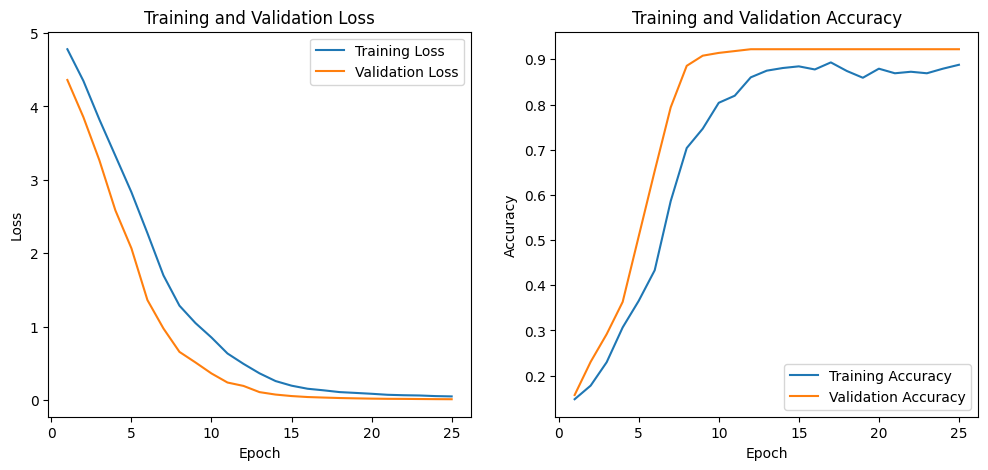

Original in English: I am cold
Predicted Translation in French: j'ai


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn import Transformer
import math
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def tokenize(text):
    return text.lower().split()

def build_vocab(sentences):
    tokens = [token for sentence in sentences for token in tokenize(sentence)]
    vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2}
    vocab.update({token: i+3 for i, token in enumerate(sorted(set(tokens)))})
    return vocab

class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab):
        self.src_sentences = [[src_vocab[token] for token in ['<sos>'] + tokenize(sentence) + ['<eos>']] for sentence in src_sentences]
        self.tgt_sentences = [[tgt_vocab[token] for token in ['<sos>'] + tokenize(sentence) + ['<eos>']] for sentence in tgt_sentences]

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        return torch.tensor(self.src_sentences[idx]), torch.tensor(self.tgt_sentences[idx])

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=0, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=0, batch_first=True)
    return src_batch, tgt_batch


english_sentences, french_sentences = zip(*english_to_french)
src_vocab = build_vocab(english_sentences)
tgt_vocab = build_vocab(french_sentences)

train_dataset = TranslationDataset(english_sentences, french_sentences, src_vocab, tgt_vocab)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.src_tok_emb = nn.Embedding(input_dim, d_model)
        self.tgt_tok_emb = nn.Embedding(output_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)
        self.transformer = Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, batch_first=True)
        self.generator = nn.Linear(d_model, output_dim)

    def forward(self, src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt, pad_idx):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len).to(device)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)

    src_padding_mask = (src == pad_idx).to(device)
    tgt_padding_mask = (tgt == pad_idx).to(device)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

def beam_search(model, src_tensor, src_vocab, tgt_vocab, beam_size=3, max_len=200):
    initial_output = torch.LongTensor([[tgt_vocab['<sos>']]]).to(device)
    candidates = [(initial_output, 0)]
    
    for _ in range(max_len):
        new_candidates = []
        for candidate, score in candidates:
            if candidate[0, -1] == tgt_vocab['<eos>']:
                new_candidates.append((candidate, score))
                continue
            output = model(src_tensor, candidate, *create_mask(src_tensor, candidate, src_vocab['<pad>']))
            probabilities = nn.functional.softmax(output[0, -1], dim=0)
            top_probabilities, top_indices = torch.topk(probabilities, beam_size)
            for i in range(beam_size):
                new_candidate = torch.cat((candidate, top_indices[i].unsqueeze(0).unsqueeze(0)), dim=-1)
                new_score = score + torch.log(top_probabilities[i]).item()
                new_candidates.append((new_candidate, new_score))
        candidates = sorted(new_candidates, key=lambda x: x[1], reverse=True)[:beam_size]

d_model = 512  # Embedding size
nhead = 8  # Number of heads in the multi-head attention models
num_encoder_layers = 3  # Number of sub-encoder-layers in the encoder
num_decoder_layers = 3  # Number of sub-decoder-layers in the decoder
dim_feedforward = 2048  # Dimension of the feedforward network model
dropout = 0.1  # Dropout value

transformer_model = TransformerModel(len(src_vocab), len(tgt_vocab), d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout).to(device)
optimizer = optim.Adam(transformer_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=src_vocab['<pad>'])

def train_epoch(model, train_dataloader, optimizer, criterion, pad_idx):
    model.train()
    total_loss = 0
    total_correct = 0
    total_elements = 0
    for src, tgt in train_dataloader:
        src = src.to(device)
        tgt = tgt.to(device)
        tgt_input = tgt[:, :-1]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, pad_idx)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
        optimizer.zero_grad()
        tgt_out = tgt[:, 1:]  # Offset by one for the targets
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = logits.max(-1)
        total_correct += (predicted == tgt_out).sum().item()
        total_elements += tgt_out.numel()

    return total_loss / len(train_dataloader), total_correct / total_elements

# Define Validation Dataset
validation_dataset = TranslationDataset(english_sentences, french_sentences, src_vocab, tgt_vocab)

# Define Validation Dataloader
validation_dataloader = DataLoader(validation_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

def validate(model, validation_dataloader, criterion, pad_idx):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_elements = 0
    with torch.no_grad():
        for src, tgt in validation_dataloader:
            src = src.to(device)
            tgt = tgt.to(device)
            tgt_input = tgt[:, :-1]
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, pad_idx)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
            tgt_out = tgt[:, 1:]  # Offset by one for the targets
            loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = logits.max(-1)
            total_correct += (predicted == tgt_out).sum().item()
            total_elements += tgt_out.numel()

    return total_loss / len(validation_dataloader), total_correct / total_elements
   
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training Loop with Validation
num_epochs = 25
for epoch in range(num_epochs):
    # Train
    epoch_train_loss, epoch_train_accuracy = train_epoch(transformer_model, train_dataloader, optimizer, criterion, src_vocab['<pad>'])
    # Validate
    epoch_val_loss, epoch_val_accuracy = validate(transformer_model, validation_dataloader, criterion, src_vocab['<pad>'])
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)
    print(f"Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")


def translate_sentence(model, sentence, src_vocab, tgt_vocab, device, max_len=200):
    model.eval()
    with torch.no_grad():
        # Tokenize and numericalize the input sentence
        src_tokens = ['<sos>'] + tokenize(sentence.lower()) + ['<eos>']
        src_indices = [src_vocab[token] for token in src_tokens if token in src_vocab]
        src_tensor = torch.LongTensor(src_indices).unsqueeze(0).to(device)
        tgt_tensor = torch.LongTensor([[tgt_vocab['<sos>']]]).to(device)

        for i in range(max_len):
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src_tensor, tgt_tensor, src_vocab['<pad>'])
            output = model(src_tensor, tgt_tensor, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
            output_token = output.argmax(-1)[:,-1]
            if output_token.item() == tgt_vocab['<eos>']:
                break

            tgt_tensor = torch.cat((tgt_tensor, output_token.unsqueeze(1)), dim=1)
        translated_tokens = [list(tgt_vocab.keys())[list(tgt_vocab.values()).index(token.item())] for token in tgt_tensor.squeeze()]

    # Remove <sos> and <eos> tokens and join the tokens into a sentence
    translated_sentence = ' '.join(translated_tokens[1:-1])
    return translated_sentence

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Call the plotting function
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

# Example usage
original_sentence = "I am cold"
predicted_translation = translate_sentence(transformer_model, original_sentence, src_vocab, tgt_vocab, device)
print("Original in English:", original_sentence)
print("Predicted Translation in French:", predicted_translation)